<a href="https://colab.research.google.com/github/ikbenali/ReproducibilityProject_DL/blob/main/Implementation_2/Reproducibility_project_PINN's_NTK_perspective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS4240: Reproducibility project

**Paper**: PINNs through a NTK perspective

Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

1D Poisson PDE functions

In [2]:
# Forcing function
def f(x):
    return -16 * np.pi ** 2 * torch.sin(4 * np.pi * x)

# Boundary condition
def g(x):
    return torch.zeros_like(x)

PINN Class

In [3]:
class PINN(nn.Module):

      def __init__(self, input_size, neurons, output_size):
        super(PINN, self).__init__()
        
        # Define layers
        self.layer1 = nn.Linear(input_size, neurons)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(neurons, output_size)

      def forward(self, x):
        
        # Calculate output of each layer for input x
        x.requires_grad_(True)
        u1 = self.layer1(x)
        a = self.sigmoid(u1)
        uhat = self.layer2(a)
        
        # Calculate second derivative of uhat: 'uhat_xx'
        uhat_x = torch.autograd.grad(uhat, x, grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
        uhat_xx = torch.autograd.grad(uhat_x, x, grad_outputs=torch.ones_like(uhat_x), create_graph=True)[0]

        return uhat, uhat_xx

      def numel(self):
        return sum([p.numel() for p in self.parameters()])

      def get_ntk(self, x):
          n = x.size()[0]

          # Calculate Jacobian of uhat wrt to the parameters for NTK
          jacobian_uhat = torch.zeros(n, self.numel())
          jacobian_uhat_xx = torch.zeros(n, self.numel())

          for i in range(n):
              uhat_i, uhat_xx_i = self.forward(x[i:i+1, :])
              grad_output = torch.ones_like(uhat_i)
              self.zero_grad()
              uhat_i.backward(grad_output, retain_graph=True)
              jacobian_uhat[i] = torch.cat([param.grad.reshape(-1) if param.grad is not None else torch.zeros_like(param).reshape(-1) for param in self.parameters()])

              grad_output = torch.ones_like(uhat_xx_i)
              self.zero_grad()
              uhat_xx_i.backward(grad_output, retain_graph=True)
              jacobian_uhat_xx[i] = torch.cat([param.grad.reshape(-1) if param.grad is not None else torch.zeros_like(param).reshape(-1) for param in self.parameters()])

          ntk_uhat = jacobian_uhat @ jacobian_uhat.T
          ntk_uhat_xx = jacobian_uhat_xx @ jacobian_uhat_xx.T

          return ntk_uhat.detach(), ntk_uhat_xx.detach()

Model

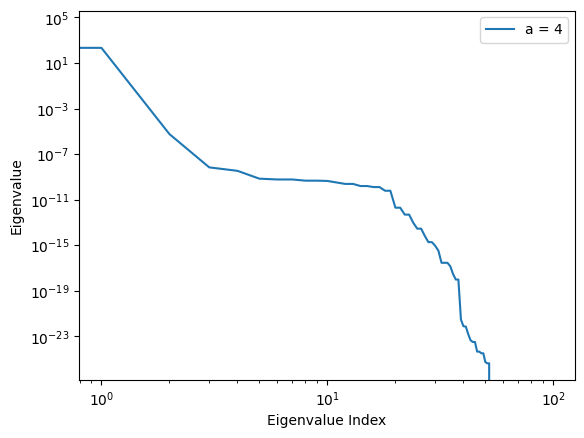

torch.Size([100, 100])


In [4]:
# Initialize model
model = PINN(input_size=1, neurons=500, output_size=1)

# Set xr and xb
nr = 100
xr = torch.rand(nr, 1)
nb = 100
xb = torch.cat((torch.zeros(nb//2, 1), torch.ones(nb//2, 1)), dim=0)
perm = torch.randperm(nb)
xb = xb[perm]

# Compute NTK for xr and xb
ntk_uhatr, ntk_uhatr_xx = model.get_ntk(xr)
ntk_uhatb, ntk_uhatb_xx = model.get_ntk(xb)

# Compute eigenvalues for ntk_uhatb
eigenvalues_uhatb,_ = torch.linalg.eig(ntk_uhatb)

# Compute eigenvalues for ntk_uhatr_xx
eigenvalues_uhatr_xx,_ = torch.linalg.eig(ntk_uhatr_xx)

# Convert tensors to NumPy arrays
eigenvalues_uhatb_np = torch.real(eigenvalues_uhatb).numpy()
eigenvalues_uhatr_xx_np = torch.real(eigenvalues_uhatr_xx).numpy()

# Sort eigenvalues in descending order
eigenvalues_uhatb_sorted = np.sort(eigenvalues_uhatb_np)[::-1]
eigenvalues_uhatr_xx_sorted = np.sort(eigenvalues_uhatr_xx_np)[::-1]

# Plot the sorted eigenvalues against their index
plt.figure()
plt.plot(eigenvalues_uhatb_sorted, label='a = 4')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.xscale("log")  # Set log scale for x-axis
plt.yscale("log")  # Set log scale for x-axis
plt.legend()
plt.show()

print(ntk_uhatr_xx.size())

Loss function

In [5]:
def loss_fn(uhat, uhat_xx, x):

    # Separate xr and xb
    xr = x[:,0]
    xb = x[:,1]

    uhat_r = uhat[:,0];   uhat_r_xx = uhat_xx[:,0]
    uhat_b = uhat[:,1];   uhat_b_xx = uhat_xx[:,1]  
    
    # Calculate residual loss term
    f_xr = f(xr)
    residual_loss = torch.mean((uhat_r_xx - f_xr)**2)

    # Calculate residual boundary loss term
    g_xb = g(xb)
    boundary_loss = torch.mean((uhat_b - g(xb))**2)

    # Calculate total loss
    loss = residual_loss + boundary_loss

    return loss

Function for training PINN

In [6]:
def train_pinn(optimizer, optimizer_name):
    from numpy.ma.core import size
    num_epochs = 10000
    NTKinterval = 10

    trace_uhat = []
    trace_uhat_xx = []

    crate_uhat = []
    crate_uhat_xx = []

    losses = []

    # Store the initial parameter values before training
    initial_params = [p.clone().detach() for p in model.parameters()]

    # Initialize a list to store the relative change in parameter values
    relative_change = []

    # Generate 100 random samples within interval [0 1]
    nr = 100
    xr = torch.rand(nr, 1)

    # Generate 100 samples consisting of only 1's and 0's alternating randomly
    nb = 100
    xb = torch.cat((torch.zeros(nb//2, 1), torch.ones(nb//2, 1)), dim=0)
    perm = torch.randperm(nb)
    xb = xb[perm]

    for epoch in range(num_epochs):

        # Predict u(x) using PINN
        uhatr, uhatr_xx = model(xr)
        uhatb, uhatb_xx = model(xb)

        # Concatenate x1 output with x2
        uhatbatch = torch.hstack((uhatr, uhatb))
        uhatbatch_xx = torch.hstack((uhatr_xx, uhatb_xx))
        xbatch = torch.hstack((xr, xb))   

        # Calculate loss 
        loss = loss_fn(uhatbatch, uhatbatch_xx, xbatch)

        # Append the loss value
        losses.append(loss.item())

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # end loop

        # Get NTK submatrices
        if ((epoch+1) % NTKinterval == 0):
          ntk_uhatr, ntk_uhatr_xx = model.get_ntk(xr)
          ntk_uhatb, ntk_uhatb_xx = model.get_ntk(xb)

          trace_uhat.append(torch.trace(ntk_uhatb).item())
          trace_uhat_xx.append(torch.trace(ntk_uhatr_xx).item()) 

          # Calculate the normalized trace values
          crate_uhat.append(torch.trace(ntk_uhatb).item() / ntk_uhatb.shape[0])
          crate_uhat_xx.append(torch.trace(ntk_uhatr_xx).item() / ntk_uhatr_xx.shape[0]) 
        
        # Calculate the relative change in parameter values and store it
        squared_norm_diff = sum([(p - p0).pow(2).sum() for p, p0 in zip(model.parameters(), initial_params)])
        squared_norm_initial = sum([p0.pow(2).sum() for p0 in initial_params])
        relative_change.append((squared_norm_diff / squared_norm_initial).item())

        # Show loss after every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f"{optimizer_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")

    return relative_change, losses, crate_uhat, crate_uhat_xx

Execute training

In [7]:
# Initialize model
model = PINN(input_size=1, neurons=500, output_size=1)

# Set learning rate
lr = 1e-3

# Stochastic gradient descent
sgd_optim = torch.optim.SGD(model.parameters(), lr)
sgd_relative_change, sgd_losses, sgd_crate_uhat, sgd_crate_uhat_xx = train_pinn(sgd_optim, 'SGD')

# Re-initialize model
model = PINN(input_size=1, neurons=500, output_size=1)

# Adam
adam_optim = torch.optim.Adam(model.parameters(), lr)
adam_relative_change, adam_losses, adam_crate_uhat, adam_crate_uhat_xx = train_pinn(adam_optim, 'Adam')

# Create a figure with 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot relative change
ax1.plot(range(1, len(sgd_relative_change) + 1), sgd_relative_change, label='SGD')
ax1.plot(range(1, len(adam_relative_change) + 1), adam_relative_change, label='Adam')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Relative Change in Parameter Values')
ax1.legend()

# Plot loss
ax2.plot(range(1, len(sgd_losses) + 1), sgd_losses, label='SGD')
ax2.plot(range(1, len(adam_losses) + 1), adam_losses, label='Adam')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.legend()

# Plot crate values for uhat and uhat_xx
ax3.plot(range(0, len(sgd_crate_uhat) * 10, 10), sgd_crate_uhat, label='SGD uhat')
ax3.plot(range(0, len(sgd_crate_uhat_xx) * 10, 10), sgd_crate_uhat_xx, label='SGD uhat_xx')
ax3.plot(range(0, len(adam_crate_uhat) * 10, 10), adam_crate_uhat, label='Adam uhat')
ax3.plot(range(0, len(adam_crate_uhat_xx) * 10, 10), adam_crate_uhat_xx, label='Adam uhat_xx')
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Crate Values')
ax3.legend()

# Display learning rate information
fig.suptitle(f'Learning Rate: {lr}')

# Show the plots
plt.show()

SGD - Epoch [100/10000], Loss: 11903.4951
SGD - Epoch [200/10000], Loss: 8880.2451
SGD - Epoch [300/10000], Loss: 9955.2197
SGD - Epoch [400/10000], Loss: 4163.1855
SGD - Epoch [500/10000], Loss: 1875.6013
SGD - Epoch [600/10000], Loss: 1996.8162
SGD - Epoch [700/10000], Loss: 1588.4950
SGD - Epoch [800/10000], Loss: 896.6157
SGD - Epoch [900/10000], Loss: 1456.9482
SGD - Epoch [1000/10000], Loss: 999.4238
SGD - Epoch [1100/10000], Loss: 577.3567
SGD - Epoch [1200/10000], Loss: 414.7781
SGD - Epoch [1300/10000], Loss: 324.7233
SGD - Epoch [1400/10000], Loss: 1131.8693
SGD - Epoch [1500/10000], Loss: 728.6275
SGD - Epoch [1600/10000], Loss: 640.5358
SGD - Epoch [1700/10000], Loss: 877.8621
SGD - Epoch [1800/10000], Loss: 257.3954
SGD - Epoch [1900/10000], Loss: 1191.4552
SGD - Epoch [2000/10000], Loss: 1362.3889
SGD - Epoch [2100/10000], Loss: 807.3237
SGD - Epoch [2200/10000], Loss: 666.9178
SGD - Epoch [2300/10000], Loss: 555.2917
SGD - Epoch [2400/10000], Loss: 744.9040
SGD - Epoch [

KeyboardInterrupt: ignored